<a href="https://colab.research.google.com/github/ziatdinovmax/im2spec/blob/main/notebooks/beps_im2spec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive notebook for our paper "Decoding the relationship between domain structure and functionality in ferroelectrics via hidden latent variables"

Sergei V. Kalinin, Rama K. Vasudevan, and Maxim Ziatdinov

The Center for Nanophase Materials Sciences, Oak Ridge National Laboratory, Oak Ridge, TN 37831

##Downloads/imports

In [1]:
!git clone https://github.com/ziatdinovmax/im2spec.git
%cd im2spec

Cloning into 'im2spec'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 44 (delta 19), reused 20 (delta 6), pack-reused 0
Unpacking objects: 100% (44/44), done.
/content/im2spec


In [2]:
# dataset 1
!gdown https://drive.google.com/uc?id=15vT1pKN9uiGIx0g0Ru4K8Stk4TIKizEc
# dataset 2
!gdown https://drive.google.com/uc?id=16-Oi3OfhtfSvWHhKYtIV8hjasHetJDd0

Downloading...
From: https://drive.google.com/uc?id=15vT1pKN9uiGIx0g0Ru4K8Stk4TIKizEc
To: /content/im2spec/first_dataset.npz
100% 641k/641k [00:00<00:00, 43.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=16-Oi3OfhtfSvWHhKYtIV8hjasHetJDd0
To: /content/im2spec/second_dataset.npz
100% 922k/922k [00:00<00:00, 59.8MB/s]


In [49]:
import os
from copy import deepcopy as dc

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import decomposition
from sklearn.mixture import GaussianMixture
from skimage.measure import compare_ssim as ssim

from im2spec.models import im2spec, spec2im
from im2spec.utils import create_training_set, predict, loop_area, encode, decode, latent_gmm
from im2spec.train_utils import trainer

## Data inspection

Load data into the notebook:

In [4]:
hdata, spec_val = np.load("second_dataset.npz").values()

Plot averaged loop:

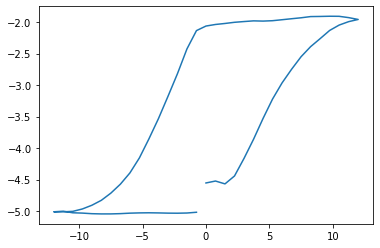

In [5]:
plt.plot(spec_val, hdata.mean(axis=(0,1)))
plt.show()

Plot spatial map at selected voltage:

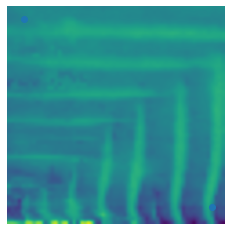

In [6]:
voltage_step = 0

plt.imshow(hdata[:, :, voltage_step], origin="lower", interpolation="Gaussian")
#plt.title('V = {}'.format(spec_val[voltage_step]))
plt.axis("off")
#plt.scatter([10, 20], [37, 37], c='red', marker='x')
plt.scatter([4, hdata.shape[0]-4], [hdata.shape[0]-4, 4])
plt.show()

Now let's do some basic decompositions to get a better understanding of the data:

In [7]:
# Select number of components
nc = 16 

# Select decomposition type ('PCA' or 'NMF')
# Obviously, we have negative data here, so the non-negativity constraint is not needed
decomposition_type = 'PCA'

d1, d2, d3 = hdata.shape
X_vec = hdata.reshape(d1*d2, d3)

# Run decomposition
if decomposition_type == 'NMF':
    clf = decomposition.NMF(n_components=nc, random_state=42)
elif decomposition_type == 'PCA':
    clf = decomposition.PCA(n_components=nc, random_state=42)
else:
    raise NotImplementedError('Available methods: "PCA", "NMF"')

X_vec_t = clf.fit_transform(X_vec)
components = clf.components_
components = components.reshape(nc, d3)
print(components.shape, X_vec_t.shape)

(16, 64) (3600, 16)


Plot the decomposition results:

NUMBER OF COMPONENTS: 16
Components...


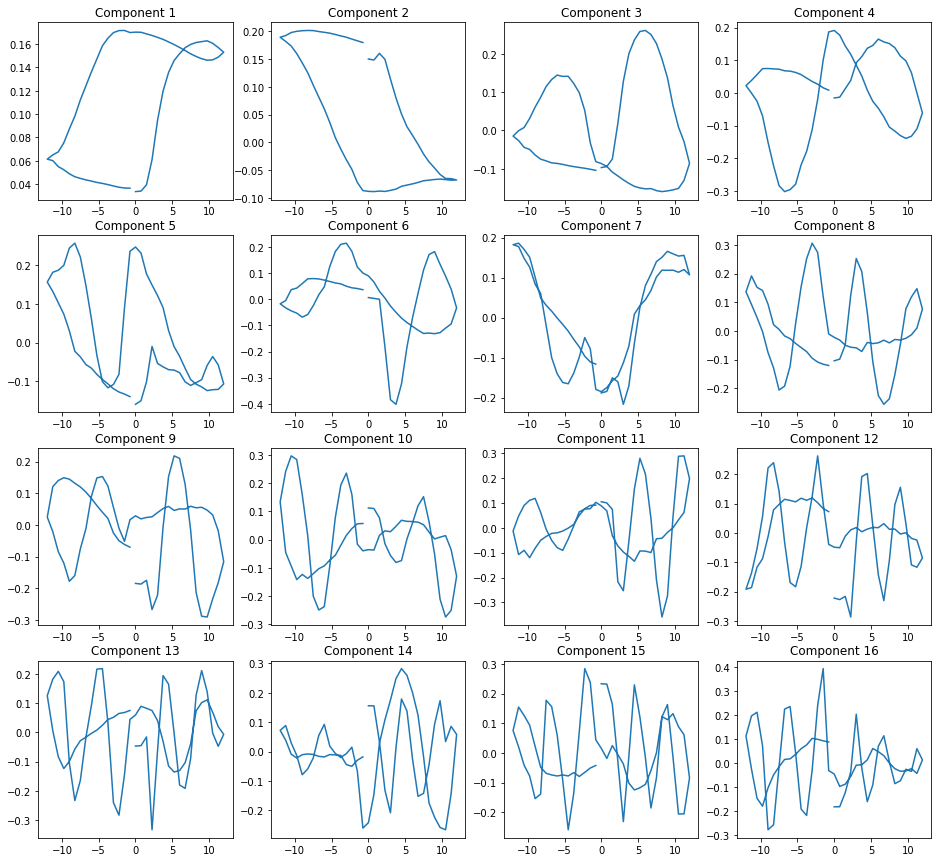

Abundance maps...


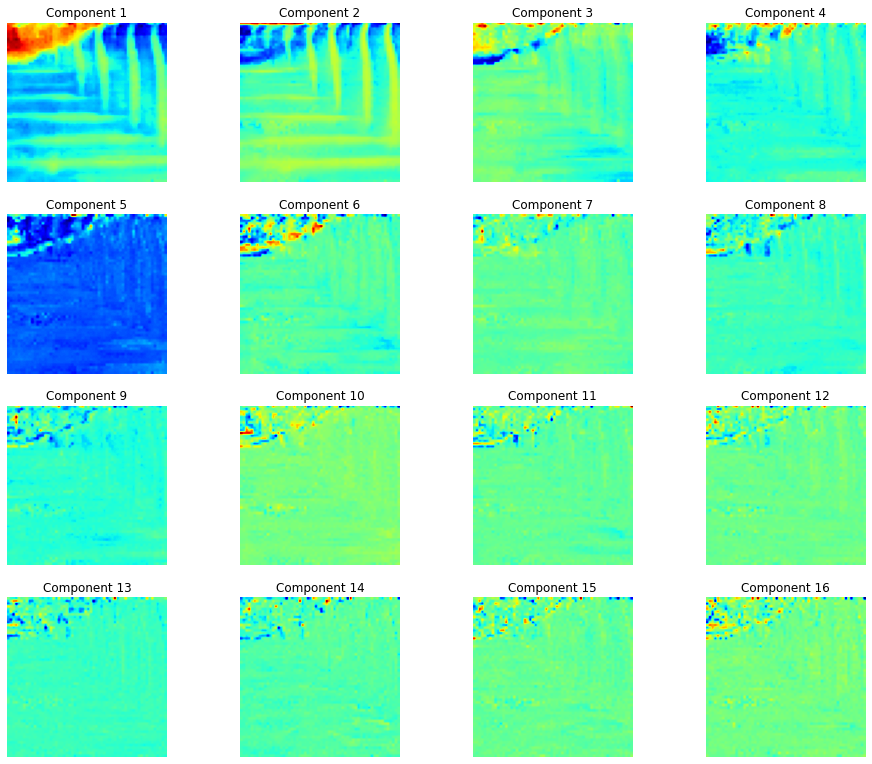

In [13]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

print('NUMBER OF COMPONENTS: ' + str(nc))
print('Components...')
gs1 = gridspec.GridSpec(rows, cols)
fig1 = plt.figure(figsize = (4*cols, 4.5*(1+rows)//1.5))   
for i in range(nc):
    ax1 = fig1.add_subplot(gs1[i])
    ax1.plot(spec_val, components[i])
    #ax1.tick_params(labelsize=15)
    ax1.set_title('Component ' + str(i + 1))
#plt.subplots_adjust(wspace=0.3)
plt.show()

print('Abundance maps...')
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4.5*(1+rows//1.5)))   
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(X_vec_t[:, i].reshape(d1, d2), cmap = 'jet')
    ax2.set_title('Component ' + str(i + 1))
    ax2.axis("off")
plt.show()


# ML analysis

Here, we are going to:
- create a training set consisting of small 2D patches of size $(w, w)$ centered at pixel coordinates $(x_i, y_i)$ of the original image at $V = 0$ and hysteresis loops at these $(x_i, y_i)$ locations.
- train *im2spec* encoder-decoder network(s) that will transform an image to spectrum via a latent layer.
- train *spec2im* network(s) that will do the "inverse" transformation.

## im2spec

Create a stack of subimages (features) and the associated loops (targets):

In [14]:
wsize = 8 # window size for cropping 2D patches from a "mother" image 
pos_arr, feature_arr, target_arr = create_training_set(hdata, window_size=wsize)
print(feature_arr.shape, target_arr.shape)

(2809, 1, 8, 8) (2809, 1, 64)


Split into train and test sets such that there is no spatial overlap between images in to sets:

In [15]:
split = [pos_arr[:, 1] <= 42, pos_arr[:, 1] > 42] # train, test

X_test = feature_arr[split[1]]
y_test = target_arr[split[1]]
X_train = feature_arr[split[0]]
y_train = target_arr[split[0]]
pos_test = pos_arr[split[1]]
pos_train = pos_arr[split[0]]

Train *imspec* model for different dimensions of the latent space:

In [ ]:
latent_dims = [2, 10]

trained_imspec = []
for ldim in latent_dims:
    print("Training model with {} latent dimensions".format(ldim))
    model = im2spec((wsize, wsize), 64, ldim)
    trained_model = trainer(
        model, X_train, y_train, X_test, y_test,
        num_epochs=250, savename="im2spec_lv{}".format(ldim)).run()
    trained_imspec.append(dc(trained_model))

Calculate prediction error:

Model with 2 latent dimensions


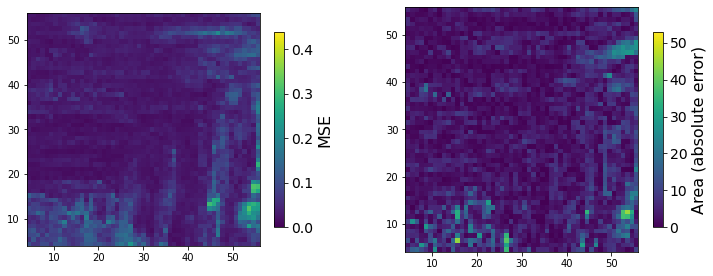

Model with 10 latent dimensions


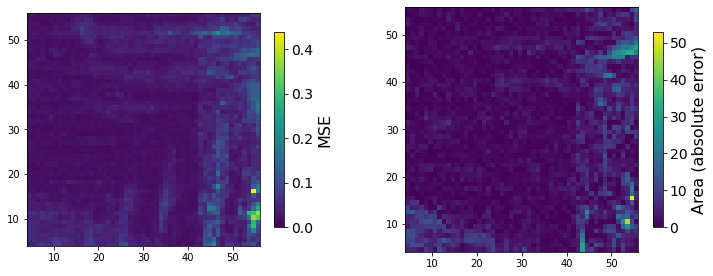

In [20]:
for model, ldim in zip(trained_imspec, latent_dims):
    print("Model with {} latent dimensions".format(ldim))
    pred_loop = predict(model, feature_arr)
    pred_area, target_area, area_error = loop_area(pred_loop, target_arr, spec_val)

    ms_error = (np.mean((pred_loop-target_arr)**2,axis = -1) /
            np.mean((pred_loop+target_arr)**2,axis = -1))**(1/2)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
    fig.subplots_adjust(wspace=0.3)
    reshape_ = int(np.sqrt(ms_error.shape[0]))
    im1 = axes[0].imshow(ms_error.reshape(reshape_, reshape_),
                        cmap='viridis', origin="lower", vmin=0, vmax=0.44,
                        extent=(pos_arr[:, 0].min(), pos_arr[:, 0].max(),
                                pos_arr[:, 1].min(), pos_arr[:, 1].max()))
    cbar1 = fig.colorbar(im1, ax=axes[0], shrink=.8)
    cbar1.set_label("MSE", fontsize=16)
    cbar1.ax.tick_params(labelsize=14)
    im2 = axes[1].scatter(pos_arr[:, 1], pos_arr[:, 0],
                        c=area_error, s=64, marker='s', cmap='viridis',
                        vmin=0, vmax=53)
    axes[1].set_xlim(pos_arr[:, 0].min(), pos_arr[:, 0].max())
    axes[1].set_ylim(pos_arr[:, 1].min(), pos_arr[:, 1].max())
    cbar2 = fig.colorbar(im2, ax=axes[1], shrink=.8)
    cbar2.set_label("Area (absolute error)", fontsize=16)
    cbar2.ax.tick_params(labelsize=14)
    plt.show()

Prediction for individual samples:

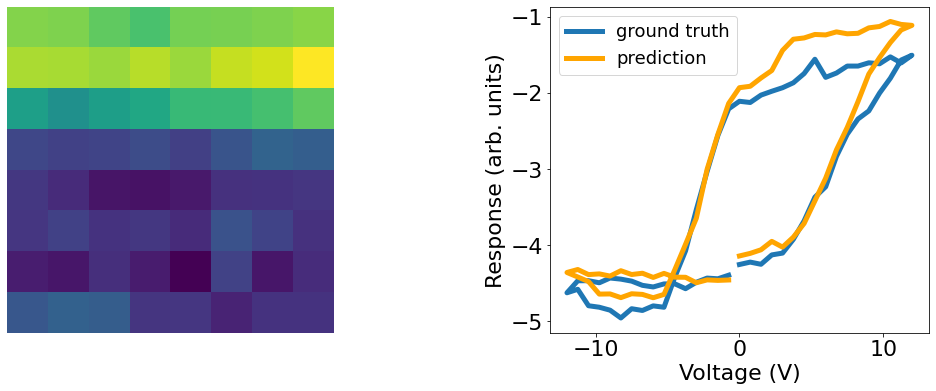

In [21]:
# use it to find id of point(s) with from the error maps above
pos = [50, 31]
k = [i for i, p in enumerate(pos_arr) if np.equal(p, pos).all()][0]
# select one of the trained models
model = trained_imspec[1]

# Make a prediction
prediction = predict(model, feature_arr[k:k+1])
# Plot results
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))
ax1.imshow(feature_arr[k, 0], origin="lower")#interpolation="gaussian")
ax1.axis(False)
ax2.plot(spec_val, target_arr[k, 0], linewidth=5, label='ground truth')
ax2.plot(spec_val, prediction[0, 0], linewidth=5, color='orange', label='prediction')
ax2.set_xlabel("Voltage (V)", fontsize=22)
ax2.set_ylabel("Response (arb. units)", fontsize=22)
ax2.tick_params(axis='both', which='major', labelsize=22)
#ax2.set_ylim(-10, 2.5)
ax2.legend(fontsize=18, loc='upper left')
plt.subplots_adjust(wspace=0.5)

Now let's get latent variables and analyze them:

Model with 2 latent dimensions


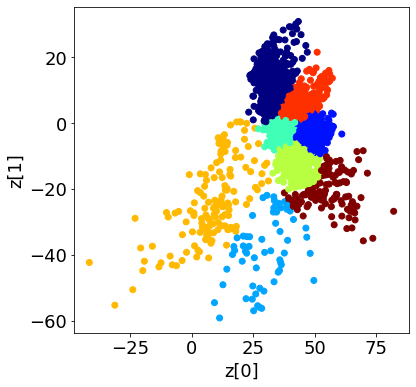

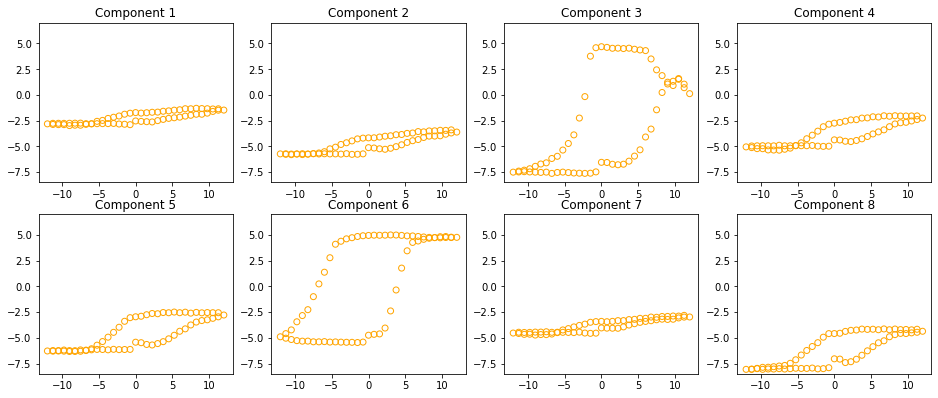

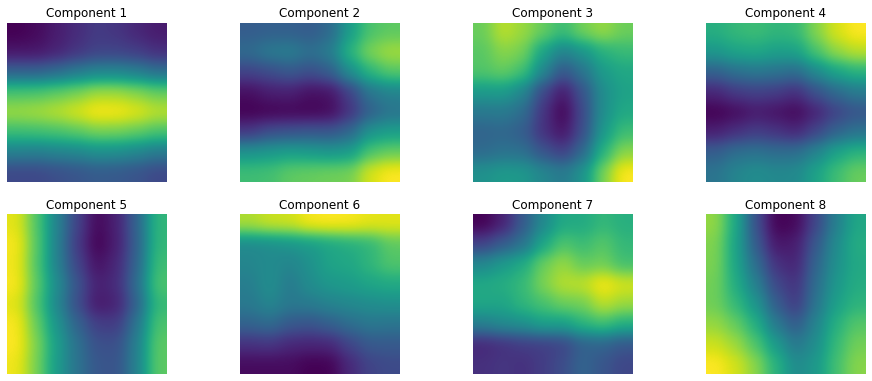

Model with 10 latent dimensions


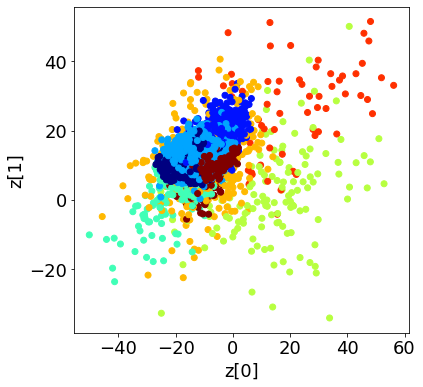

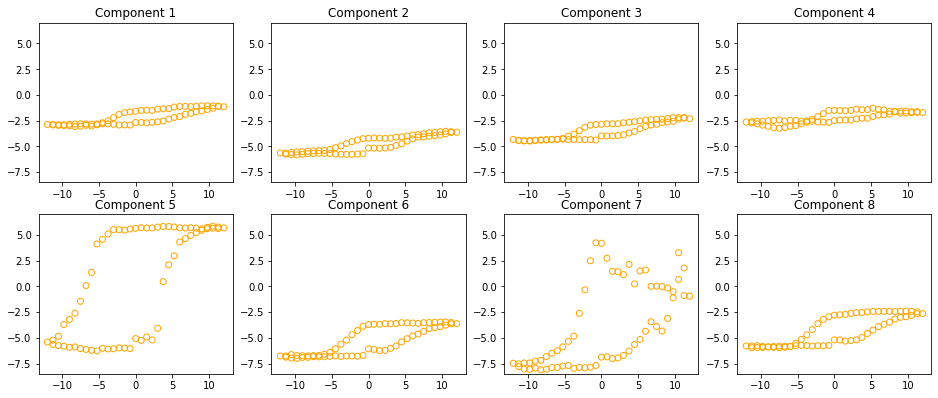

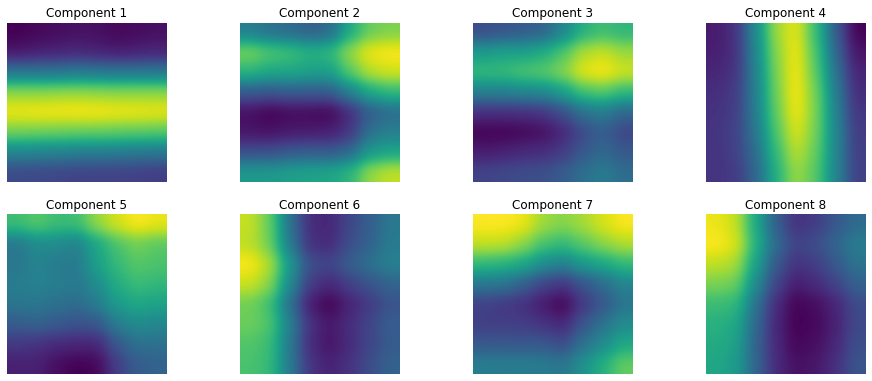

In [27]:
for model, ldim in zip(trained_imspec, latent_dims):
    print("Model with {} latent dimensions".format(ldim))
    (latent_features, gmm_zp,
     centroids, decoded_centroids) = latent_gmm(model, feature_arr, nc=8)
    plt.figure(figsize=(6,6))
    plt.scatter(latent_features[:, 0], latent_features[:,1], c=gmm_zp, cmap='jet')
    plt.xlabel("z[0]", fontsize = 18)
    plt.ylabel("z[1]", fontsize = 18)
    plt.tick_params(labelsize = 18)
    plt.show()
    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure(figsize = (4*cols, 4.5*(1+rows//1.5)))   
    for i, centroid in enumerate(decoded_centroids):
        ax = fig.add_subplot(gs[i])
        ax.scatter(spec_val, centroid,
                    marker='o', color="orange", facecolors='none')
        ax.set_title('Component ' + str(i + 1))
        ax.set_ylim(-8.5, 7)
    plt.show()
    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure(figsize = (4*cols, 4.5*(1+rows//1.5)))   
    for i, centroid in enumerate(centroids):
        ax = fig.add_subplot(gs[i])
        comp_arr = []
        for n, feature in enumerate(latent_features):
            comp = np.sum((feature - np.squeeze(centroids[i]))**2)
            comp_arr = np.append(comp_arr, comp)
        loc_im = feature_arr[np.argsort(comp_arr)[:100],:, :].mean(axis = 0)
        ax.imshow(loc_im[0], interpolation="gaussian")
        ax.set_title('Component ' + str(i + 1))
        ax.axis(False)
    plt.show()


Do the "inverse" encoder trick to get continous representation for the features (works only for 2 latent dimensions):

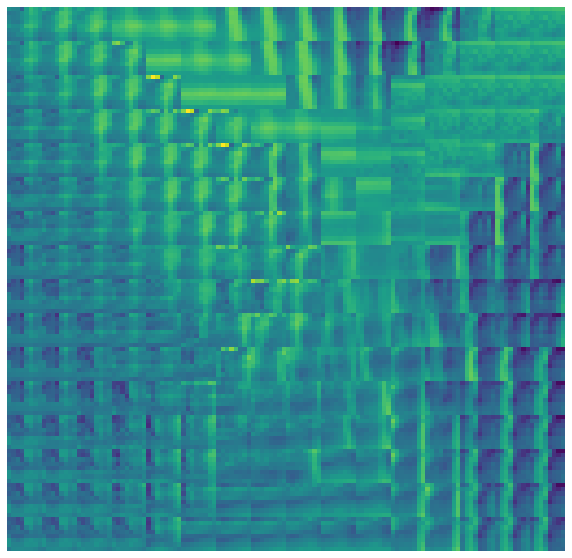

In [31]:
latent_features = encode(trained_imspec[0], feature_arr)

if latent_features.shape[-1] != 2:
    raise ValueError("Your latent vector last dimension must be equal to 2")

xmin = latent_features[:, 0].min()
ymin = latent_features[:, 1].min()
xmax = latent_features[:, 0].max()
ymax = latent_features[:, 1].max()

n = 16
window_size1 = wsize
window_size2 = wsize
figure = np.zeros((window_size1 * n, window_size2 * n))

# linearly spaced coordinates corresponding to the 2D plot
# of spectrum classes in the latent space
grid_x = np.linspace(xmin, xmax, n)
grid_y = np.linspace(ymin, ymax, n)[::-1]
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z = np.array([[xi, yi]])
        comp_arr = []
        for n, feature in enumerate(latent_features):
          comp = np.sum((feature - np.squeeze(z))**2)
          comp_arr.append(comp)
        loc_im = feature_arr[np.argsort(comp_arr)[:3],:, :].mean(axis=0)

        figure[i * window_size1: (i + 1) * window_size1,
               j * window_size2: (j + 1) * window_size2] = loc_im

plt.figure(figsize=(10, 10))
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='viridis', aspect='auto')
plt.axis(False)
plt.show()

## spec2im

Now we are going to interchange target and features and constuct *spec2im* network to predict 2D images from 1D loops.

In [ ]:
latent_dims = [2, 10]

trained_specim = []
for ldim in latent_dims:
    print("Training model with {} latent dimensions".format(ldim))
    model = spec2im(64, (wsize, wsize), ldim)
    trained_model = trainer(
        model, y_train, X_train, y_test, X_test,
        num_epochs=250, savename="spec2im_lv{}".format(ldim)).run()
    trained_specim.append(dc(trained_model))

Get spatial error maps:

Model with 2 latent dimensions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


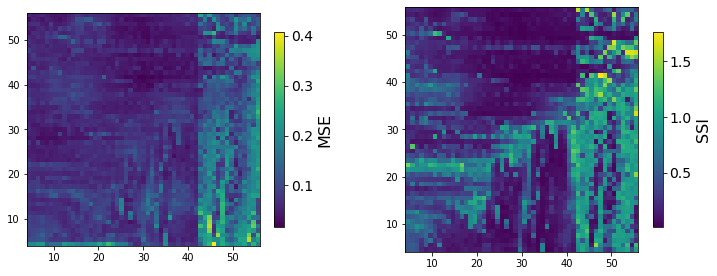

Model with 10 latent dimensions


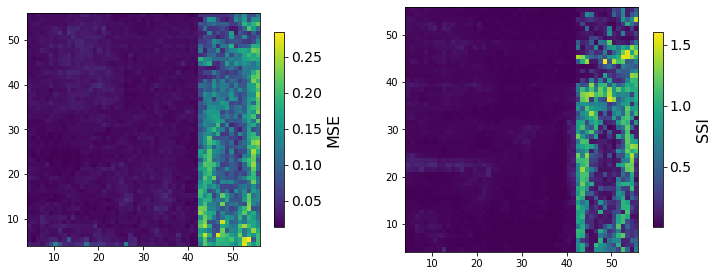

In [38]:
for model, ldim in zip(trained_specim, latent_dims):
    print("Model with {} latent dimensions".format(ldim))
    pred_im = predict(model, target_arr) 
    
    ssim_idx = [1-ssim(im1, im2) for (im1, im2) in zip(feature_arr[:,0], pred_im[:,0])]
    ms_error = (np.mean((pred_im-feature_arr)**2,axis = (-2,-1)) /
            (np.mean((pred_im+feature_arr)**2,axis = (-2,-1))))**(1/2)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
    fig.subplots_adjust(wspace=0.3)
    reshape_ = int(np.sqrt(ms_error.shape[0]))
    im1 = axes[0].imshow(ms_error.reshape(reshape_, reshape_), cmap='viridis', origin="lower",
                        extent=(pos_arr[:, 0].min(), pos_arr[:, 0].max(),
                                pos_arr[:, 1].min(), pos_arr[:, 1].max()))
    cbar1 = fig.colorbar(im1, ax=axes[0], shrink=.8)
    cbar1.set_label("MSE", fontsize=16)
    cbar1.ax.tick_params(labelsize=14)
    im2 = axes[1].scatter(pos_arr[:, 1], pos_arr[:, 0],
                c=ssim_idx, s=64, marker='s', cmap='viridis')
    axes[1].set_xlim(pos_arr[:, 0].min(), pos_arr[:, 0].max())
    axes[1].set_ylim(pos_arr[:, 1].min(), pos_arr[:, 1].max())
    cbar2 = fig.colorbar(im2, ax=axes[1], shrink=.8)
    cbar2.set_label("SSI", fontsize=16)
    cbar2.ax.tick_params(labelsize=14)
    plt.show()

Individual predictions:

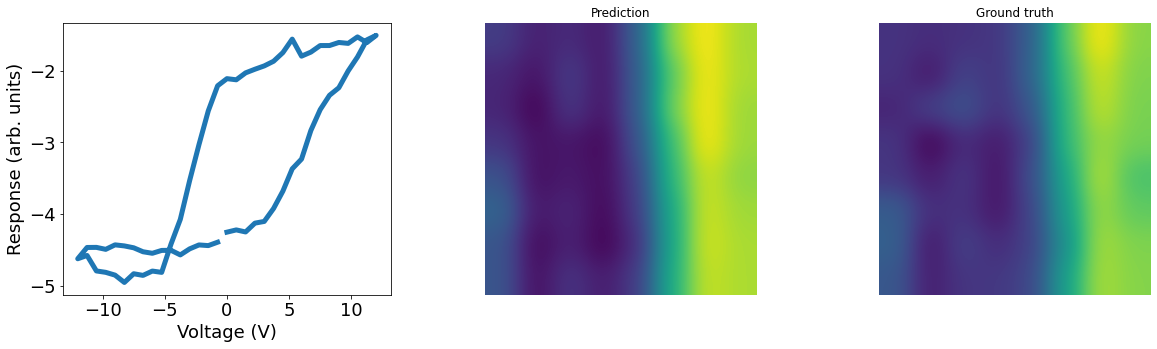

In [60]:
# use it to find id of point(s) with from the error maps above
pos = [50, 31]
k = [i for i, p in enumerate(pos_arr) if np.equal(p, pos).all()][0]
# select one of the trained models
model = trained_imspec[1]

# prediction with a trained model
prediction = predict(model, target_arr[k:k+1])
# plot results
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.plot(spec_val, target_arr[k, 0, :], linewidth=5)
ax1.set_xlabel("Voltage (V)", fontsize=18)
ax1.set_ylabel("Response (arb. units)", fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.imshow(prediction[0, 0], origin="lower", interpolation="gaussian")
ax2.set_title("Prediction")
ax2.axis(False)
ax3.imshow(feature_arr[k, 0], origin="lower", interpolation="gaussian")
ax3.set_title("Ground truth")
ax3.axis(False)
plt.show()

Analyze latent sapce of the spec2im model:

Model with 2 latent dimensions


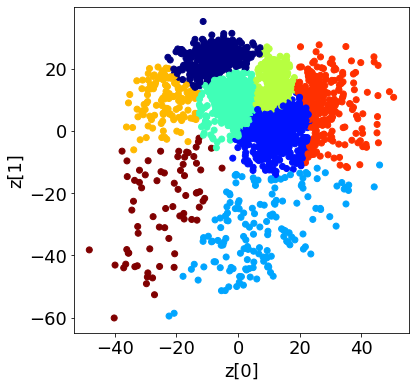

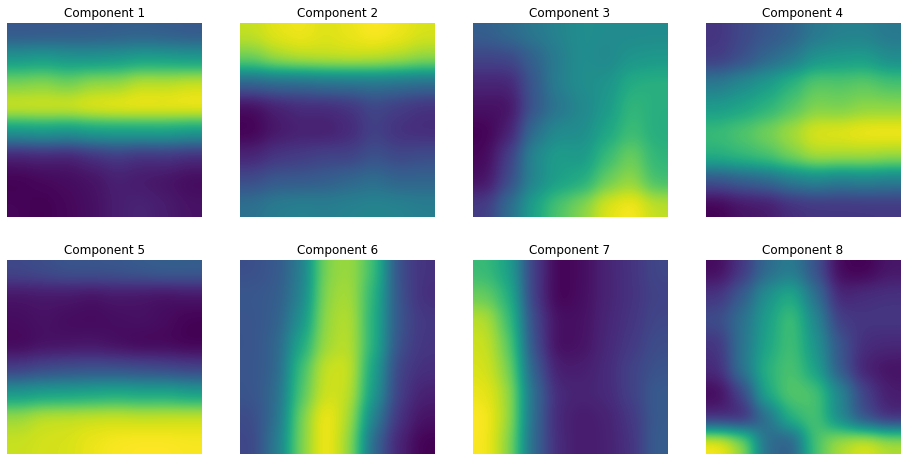

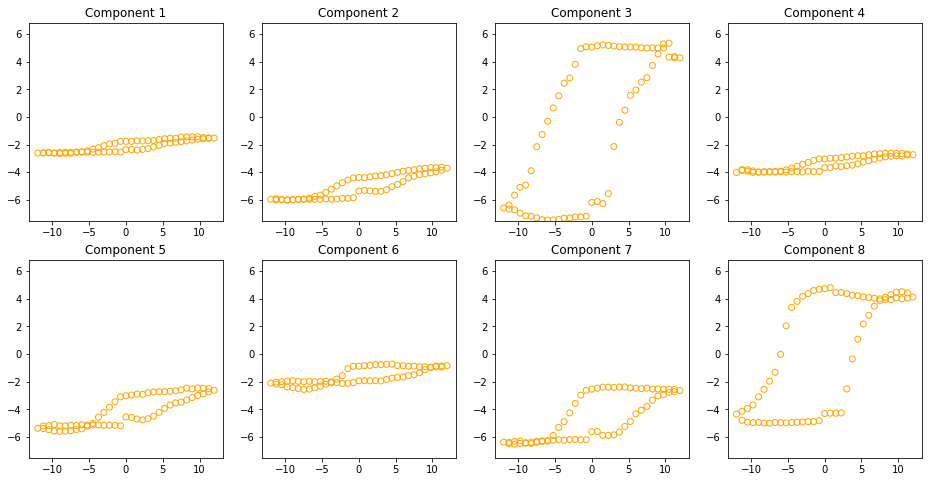

Model with 10 latent dimensions


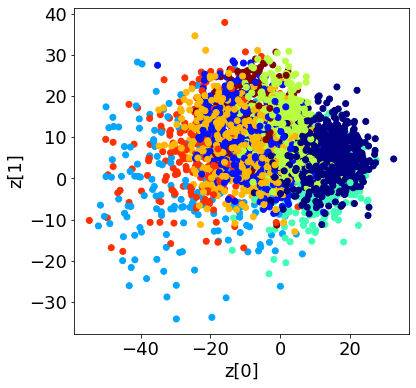

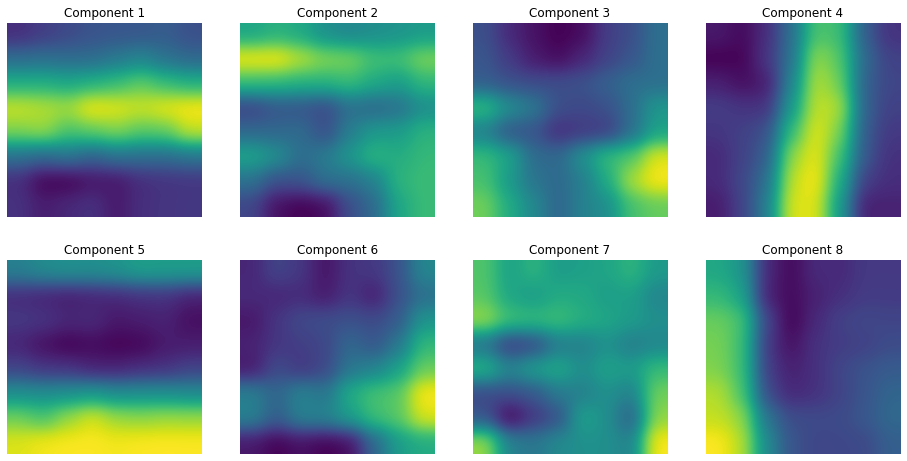

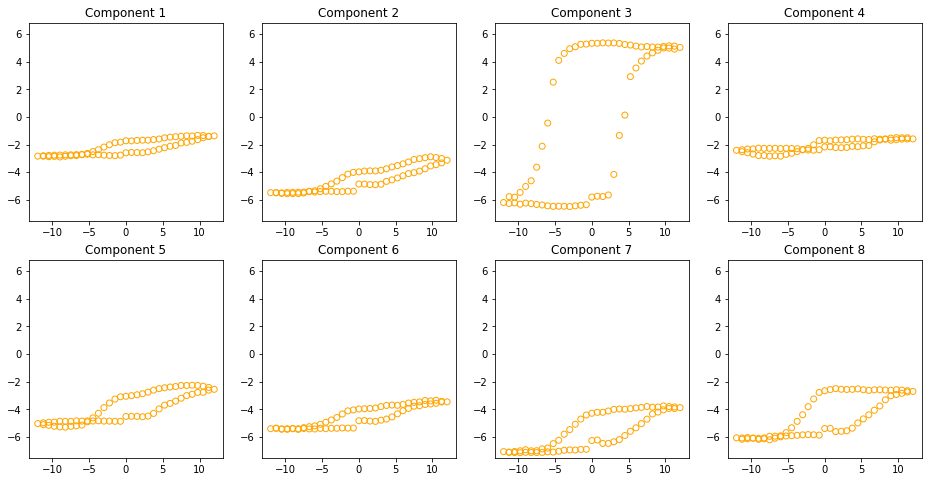

In [59]:
for model, ldim in zip(trained_specim, latent_dims):
    print("Model with {} latent dimensions".format(ldim))
    (latent_features, gmm_zp,
     centroids, decoded_centroids) = latent_gmm(model, target_arr, nc=8)
    plt.figure(figsize=(6,6))
    plt.scatter(latent_features[:, 0], latent_features[:,1], c=gmm_zp, cmap='jet')
    plt.xlabel("z[0]", fontsize = 18)
    plt.ylabel("z[1]", fontsize = 18)
    plt.tick_params(labelsize = 18)
    plt.show()
    rows = int(np.ceil(float(nc)/4))
    cols = int(np.ceil(float(nc)/rows))
    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure(figsize=(4*cols, 4*(1+rows//1.5)))   
    for i, centroid in enumerate(decoded_centroids):
        ax = fig.add_subplot(gs[i])
        ax.imshow(np.squeeze(centroid) ,interpolation="gaussian", origin="lower")
        ax.set_title('Component ' + str(i + 1))
        ax.axis(False)
    plt.show()
    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))   
    for i, centroid in enumerate(decoded_centroids):
        ax = fig.add_subplot(gs[i])
        comp_arr = []
        for n, feature in enumerate(latent_features):
            comp = np.sum((feature-np.squeeze(centroids[i]))**2)
            comp_arr = np.append(comp_arr, comp)
        loc_loop = target_arr[np.argsort(comp_arr)[:10],:].mean(axis = 0)
        ax.scatter(spec_val, loc_loop, marker='o', color='orange', facecolors='none')
        ax.set_title('Component ' + str(i + 1))
        ax.set_ylim(-7.5, 6.8)
    plt.show()

Finally, we reconstruct a 2D manifold with different domain structures from the latent variables:

(works only for 2 latent dimensions)

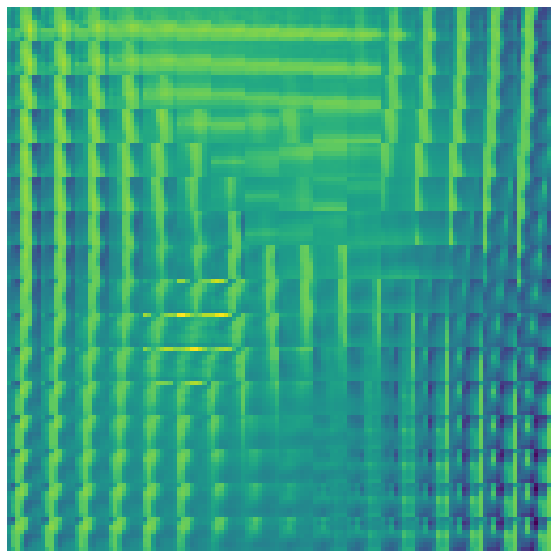

In [52]:
model = trained_specim[0]
latent_features = encode(model, target_arr)

if latent_features.shape[-1] != 2:
    raise ValueError("Your latent vector last dimension must be equal to 2")

xmin = latent_features[:, 0].min()
ymin = latent_features[:, 1].min()
xmax = latent_features[:, 0].max()
ymax = latent_features[:, 1].max()

n = 16
window_size = wsize
figure = np.zeros((window_size * n, window_size * n))

# linearly spaced coordinates corresponding to the 2D plot
# of spectrum classes in the latent space
grid_x = np.linspace(xmin, xmax, n)
grid_y = np.linspace(ymin, ymax, n)[::-1]
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        x_decoded = decode(model, np.array([xi, yi]))
        local_im = x_decoded[0].reshape(window_size, window_size)
        figure[i * window_size: (i + 1) * window_size,
               j * window_size: (j + 1) * window_size] = local_im

plt.figure(figsize=(10, 10))
start_range = window_size // 2
end_range = n * window_size + start_range + 1
pixel_range = np.arange(start_range, end_range, window_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='viridis')
plt.axis("off")
plt.show()
